In [ ]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# load nodes details
with open("fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

In [ ]:
# captture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 214157.28it/s]


In [ ]:
fb_df.head()

node_1 node_2
0      0    276
1      0     58
2      0    132
3      0    603
4      0    398

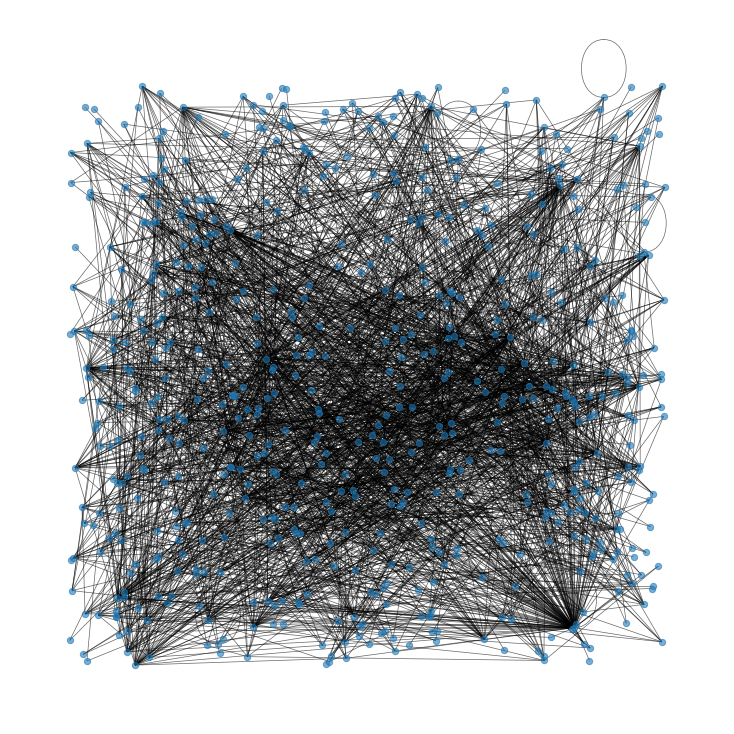

In [ ]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [ ]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [ ]:
adj_G.shape

(620, 620)

In [ ]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:11<00:00, 54.60it/s] 


In [ ]:
len(all_unconnected_pairs)

19018

In [ ]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [ ]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2102/2102 [00:15<00:00, 132.52it/s]


In [ ]:
len(omissible_links_index)

1483

In [ ]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [ ]:
data['link'].value_counts()

0    19018
1     1483
Name: link, dtype: int64

In [ ]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [ ]:
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=cd4a50437045ea9f480192ef9ef7b0f22cb8490b9343c5458180e53d7d7d40b8
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [ ]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/620 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


In [ ]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [ ]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight='balanced')

In [ ]:
predictions = lr.predict_proba(xtest)

In [ ]:
roc_auc_score(ytest, predictions[:,1])

0.797813731952096

In [ ]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

In [ ]:
# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

[1]	valid_0's auc: 0.720051
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.760305
[3]	valid_0's auc: 0.788725
[4]	valid_0's auc: 0.806137
[5]	valid_0's auc: 0.819511
[6]	valid_0's auc: 0.824401
[7]	valid_0's auc: 0.833114
[8]	valid_0's auc: 0.844068
[9]	valid_0's auc: 0.84937
[10]	valid_0's auc: 0.85213
[11]	valid_0's auc: 0.856469
[12]	valid_0's auc: 0.858739
[13]	valid_0's auc: 0.864602
[14]	valid_0's auc: 0.865577
[15]	valid_0's auc: 0.866455
[16]	valid_0's auc: 0.866898
[17]	valid_0's auc: 0.867929
[18]	valid_0's auc: 0.868577
[19]	valid_0's auc: 0.869594
[20]	valid_0's auc: 0.871808
[21]	valid_0's auc: 0.874273
[22]	valid_0's auc: 0.876841
[23]	valid_0's auc: 0.878933
[24]	valid_0's auc: 0.882445
[25]	valid_0's auc: 0.884329
[26]	valid_0's auc: 0.885481
[27]	valid_0's auc: 0.886756
[28]	valid_0's auc: 0.888683
[29]	valid_0's auc: 0.889204
[30]	valid_0's auc: 0.889849
[31]	valid_0's auc: 0.891069
[32]	valid_0's auc: 0.891497
[33]	valid_0's auc: 0

In [ ]:
from xgboost import XGBClassifier

In [ ]:
clf = XGBClassifier()
clf.fit(xtrain, ytrain)

XGBClassifier()

In [ ]:
predictions = clf.predict_proba(xtest)

In [ ]:
roc_auc_score(ytest, predictions[:,1])

0.899942586627866

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classifier= RandomForestClassifier(n_estimators= 10, criterion="entropy")  
classifier.fit(xtrain, ytrain)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [ ]:
predictions = classifier.predict_proba(xtest)

In [ ]:
roc_auc_score(ytest, predictions[:,1])

0.8814241832585094